# Jukebox: Layer activation visualization

In this notebook, the objective is the explore the activations of the encoder with differet instruments.

We used the same note in 4 different instruments and realized there were some channels in the layers on the encoders that were not activated at all for some instruments and were activated for others. 

We believe that these activations could be capturing timber. 

We visualize the layers that are activated for some instruments but not for others for two notes: C4 and G4.

In [ ]:
import jukebox
import torch as t
import torch
import librosa
import os
from IPython.display import Audio
from jukebox.make_models import make_vqvae, make_prior, MODELS, make_model
from jukebox.hparams import Hyperparams, setup_hparams
from jukebox.sample import sample_single_window, _sample, \
                           sample_partial_window, upsample
from jukebox.utils.dist_utils import setup_dist_from_mpi
from jukebox.utils.torch_utils import empty_cache

import scipy
import numpy as np
import lucent
from lucent.optvis.render import hook_model
from lucent.modelzoo.util import get_model_layers
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
import pandas as pd
import seaborn as sns

rank, local_rank, device = setup_dist_from_mpi()

In [ ]:
model = "1b_lyrics" # or "1b_lyrics"     
hps = Hyperparams()
hps.sr = 44100
hps.n_samples = 3 if model=='5b_lyrics' else 8
hps.name = 'samples'
chunk_size = 16 if model=="5b_lyrics" else 32
max_batch_size = 3 if model=="5b_lyrics" else 16
hps.levels = 3
hps.hop_fraction = [.5,.5,.125]

f_start = 100
f_end = 4000
num_seconds = 10
sample_rate = 44100


vqvae, *priors = MODELS[model]
vqvae = make_vqvae(setup_hparams(vqvae, dict(sample_length = 1048576)), device)
top_prior = make_prior(setup_hparams(priors[-1], dict()), vqvae, device)
vqvae = vqvae.eval()


## 1) Extracting the activations

In [ ]:

notes_list =  ['C4','G4']
instruments_list =  ['flute', 'piano', 'trumpet','violin']

num_encoders = len(vqvae.encoders)
for note in notes_list:
  for instrument in instruments_list:

    file_name = "data/notes/{}-{}.wav".format(instrument, note)
    a = read(file_name)
    wave = np.array(a[1],dtype='int16')
    #wave = wave[-23000:-10000]
    wave = torch.from_numpy(wave).cuda().float()
    wave = wave[None, None, :]

    encoder_list = []
    names_list = []
    weights_list = []
    std_list = []
    for num_enc in range(num_encoders):
      encoder = vqvae.encoders[num_enc].eval()
      model_layers = get_model_layers(encoder)
      big_layers = [x for x in model_layers if len(x)>39]
      hook = hook_model(encoder, None)

      with torch.no_grad():
        xs = encoder(wave)

      for layer_name in big_layers:
        activations = hook(layer_name)
        b, c, n = activations.shape

        for channel_idx in range(c):
          name = '{}_channel_{}'.format(layer_name, channel_idx)
          channel_activation = activations[0, channel_idx, :]
          ch = channel_activation.detach().cpu().numpy()

          names_list.append(name)
          weights_list.append((np.mean(ch)+np.std(ch)))
          encoder_list.append(num_enc)

    df = pd.DataFrame({'names':names_list, 'weight': weights_list, 'encoder': encoder_list})
    df.to_csv('results/mean_{}_{}.csv.gz'.format(instrument, note),index=False, compression='gzip')




## 2) Visualizing the different channels-layers

In [ ]:


def view_binary(note):
  violin = pd.read_csv('./results/mean_{}_{}.csv.gz'.format('violin', note))
  violin.columns = ['names', 'violin', 'encoder']

  piano = pd.read_csv('./results/mean_{}_{}.csv.gz'.format('piano', note))
  piano.columns = ['names', 'piano', 'encoder']

  flute = pd.read_csv('./results/mean_{}_{}.csv.gz'.format('flute', note))
  flute.columns = ['names', 'flute', 'encoder']

  trumpet = pd.read_csv('./results/mean_{}_{}.csv.gz'.format('trumpet', note))
  trumpet.columns = ['names', 'trumpet', 'encoder']

  df = piano.merge(violin).merge(flute).merge(trumpet)

  df_bool = df!=0

  df_bool['global_and'] = (
  df_bool['flute'] & df_bool['trumpet'] & df_bool['piano']
  & df_bool['violin'] 
  )

  df_bool['global_or'] = (
  df_bool['flute'] | df_bool['trumpet'] | df_bool['piano']
  | df_bool['violin'] 
  )

  df_vis = df_bool[df_bool['global_and']==False]
  df_vis = df_vis[df_vis['global_or']==True]
  df_vis = df_vis[['flute', 'piano', 'trumpet', 'violin']]
  return df_vis

In [ ]:
df_c = view_binary('C4')
df_g = view_binary('G4')

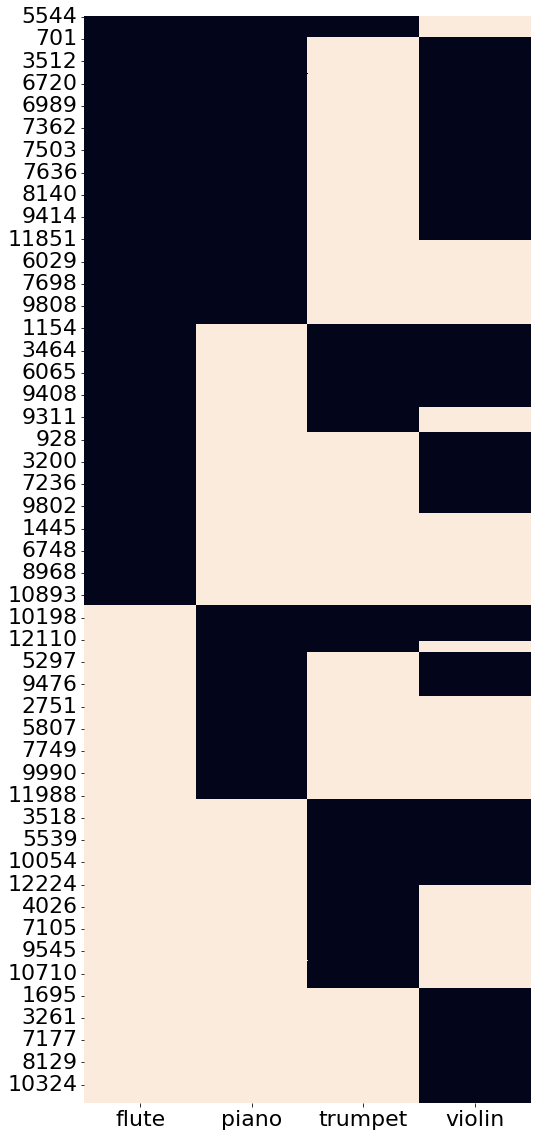

In [ ]:
plt.rcParams.update({'font.size': 22})           
plt.figure(figsize=(8,20))
ax = sns.heatmap(df_c.sort_values(['flute', 'piano', 'trumpet', 'violin']), cbar=False)
fig =ax.get_figure()
fig.savefig("./results/binary_c.png") 

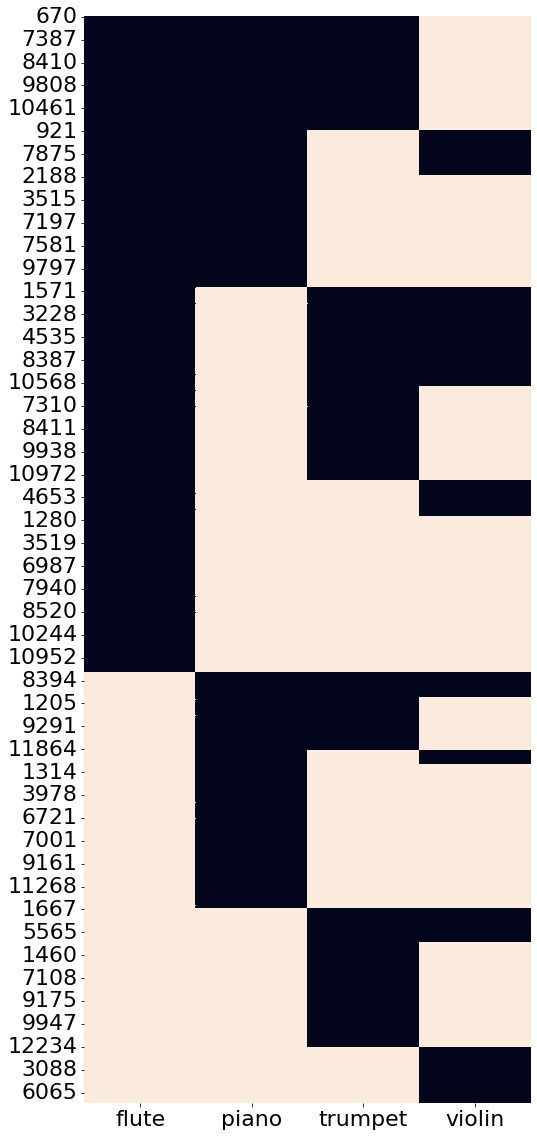

In [ ]:
plt.rcParams.update({'font.size': 22})           
plt.figure(figsize=(8,20))
ax = sns.heatmap(df_g.sort_values(['flute', 'piano', 'trumpet', 'violin']), cbar=False)
fig =ax.get_figure()
fig.savefig("./results/binary_g.png") 